<a href="https://colab.research.google.com/github/fxlmer/JSTP22_Skin-Diseases-Classification-Using-Machine-Learning/blob/master/Ex2_HAM10000_DenseNet121_Oversampling_Ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [ ]:
!nvidia-smi

Sat Feb 20 14:16:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from ham10000_6classes_utils_functions_Ver2 import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [ ]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 6

LR = 3e-5 # Learning rate

In [ ]:
np.random.seed(31)

# Data Preparation

In [ ]:
!git clone https://github.com/EvilPickle-PCSHSPT/6_classes_HAM10000_split_Ver2

Cloning into '6_classes_HAM10000_split_Ver2'...
remote: Enumerating objects: 1258, done.
remote: Counting objects: 100% (1258/1258), done.
remote: Compressing objects: 100% (1253/1253), done.
remote: Total 5434 (delta 5), reused 1257 (delta 4), pack-reused 4176
Receiving objects: 100% (5434/5434), 91.95 MiB | 35.62 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
train_path = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/' 
val_path = '/content/6_classes_HAM10000_split_Ver2/images/cc_val/'
test_path = '/content/6_classes_HAM10000_split_Ver2/images/cc_test/'

# Data Augmentation

In [ ]:
class_list = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc']

for item in class_list:

    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)

    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item

    img_list = os.listdir(train_path + img_class)

    for fname in img_list:
        # source path to image
        src = os.path.join(train_path + img_class, fname)
        # destination path to image
        dst = os.path.join(img_dir, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = train_path + img_class

    # Create a data generator to augment the images in real time
    datagen = ImageDataGenerator(rotation_range=360,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='reflect')

    batch_size = 32

    aug_datagen = datagen.flow_from_directory(path,
                                              save_to_dir=save_path,
                                              save_format='jpg',
                                              target_size=(224, 224),
                                              batch_size=batch_size)

    # Generate the augmented images and add them to the training folders
    num_aug_images_wanted = 2000  # total number of images we want to have in each class
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)

    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 410 images belonging to 1 classes.
Found 646 images belonging to 1 classes.
Found 1384 images belonging to 1 classes.
Found 144 images belonging to 1 classes.
Found 1400 images belonging to 1 classes.
Found 176 images belonging to 1 classes.


In [ ]:
print(len(os.listdir('/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/akiec/')))
print(len(os.listdir('/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/bcc')))
print(len(os.listdir('//content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/bkl')))
print(len(os.listdir('/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/df')))
print(len(os.listdir('/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/mel')))
print(len(os.listdir('/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/vasc')))

1992
1970
2024
1824
2008
1856


In [ ]:
train_aug = ImageDataGenerator(rescale=1./255)

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_aug.flow_from_directory(train_path, 
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='categorical') 

val_generator = val_aug.flow_from_directory(val_path, 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True,
                                              class_mode='categorical') 

test_generator = test_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None)

Found 11674 images belonging to 6 classes.
Found 896 images belonging to 6 classes.
Found 334 images belonging to 6 classes.


# Model

In [ ]:
!git clone https://github.com/EvilPickle-PCSHSPT/HAM10000_DenseNet121_Ver2_model

Cloning into 'HAM10000_DenseNet121_Ver2_model'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14 (delta 0), reused 2 (delta 0), pack-reused 11
Unpacking objects: 100% (14/14), done.


## Build Model

### Base Model

In [ ]:
base_model = tf.keras.models.load_model('/content/HAM10000_DenseNet121_Ver2_model/HAM10000_DenseNet121_Ver2_model.h5')

In [ ]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
num_layers = len(base_model.layers)

In [ ]:
num_layers

429

In [ ]:
for i in range(num_layers-50):
    base_model.layers[i].trainable = False

# x = base_model.layers[num_layers-2].output
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.25)(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.25)(x)
# # x = Dense(16, activation='relu')(x)
# # x = Dropout(0.25)(x)

# prediction = Dense(NUM_CLASSES, activation='softmax')

# new_model = Model(inputs=base_model.input,outputs=prediction)

In [ ]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## Compile

In [ ]:
base_model.compile(optimizer=Adam(LR), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Callbacks

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='Ex2_HAM10000_DenseNet121_Oversampling_Ver2_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [ ]:
history = base_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/100
365/365 [==============================] - ETA: 0s - batch: 182.0000 - size: 31.9836 - loss: 0.2881 - accuracy: 0.8992

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


365/365 [==============================] - 103s 242ms/step - batch: 182.0000 - size: 31.9836 - loss: 0.2881 - accuracy: 0.8992 - val_loss: 0.7509 - val_accuracy: 0.7444
Epoch 2/100
365/365 [==============================] - 36s 98ms/step - batch: 182.0000 - size: 31.9836 - loss: 0.2068 - accuracy: 0.9333 - val_loss: 0.7379 - val_accuracy: 0.7467
Epoch 3/100
365/365 [==============================] - 35s 95ms/step - batch: 182.0000 - size: 31.9836 - loss: 0.1830 - accuracy: 0.9457 - val_loss: 0.7662 - val_accuracy: 0.7433
Epoch 4/100
365/365 [==============================] - 35s 95ms/step - batch: 182.0000 - size: 31.9836 - loss: 0.1609 - accuracy: 0.9501 - val_loss: 0.7870 - val_accuracy: 0.7455
Epoch 5/100
365/365 [==============================] - 35s 96ms/step - batch: 182.0000 - size: 31.9836 - loss: 0.1430 - accuracy: 0.9581 - val_loss: 0.7677 - val_accuracy: 0.7556
Epoch 6/100
365/365 [==============================] - 35s 96ms/step - batch: 182.0000 - size: 31.9836 - loss: 0.12

# Training Graph

## Accuracy

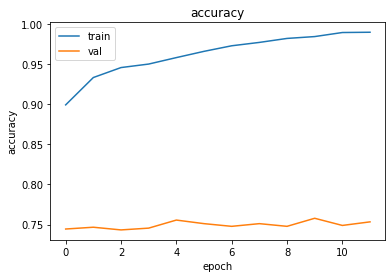

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

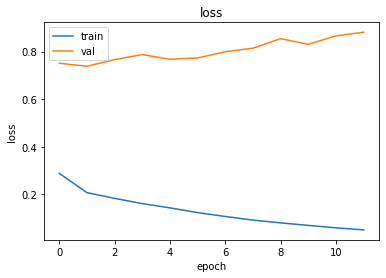

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluation

In [ ]:
test_model = tf.keras.models.load_model('/content/Ex2_HAM10000_DenseNet121_Oversampling_Ver2_model.h5')

In [ ]:
num_test_files = len(test_generator.filenames)

In [ ]:
test_generator.reset()

In [ ]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Confusion Matrix


### Without Normalize

Confusion matrix, without normalization
[[25  4  3  1  0  0]
 [ 2 48  1  0  1  0]
 [ 7  1 87  4 10  1]
 [ 0  1  0 11  0  0]
 [ 2  3 10  9 88  0]
 [ 0  0  0  1  0 14]]


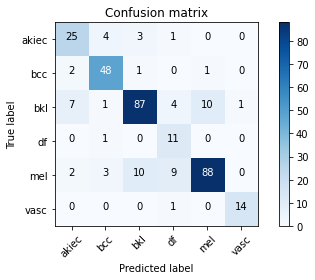

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[0.75757576 0.12121212 0.09090909 0.03030303 0.         0.        ]
 [0.03846154 0.92307692 0.01923077 0.         0.01923077 0.        ]
 [0.06363636 0.00909091 0.79090909 0.03636364 0.09090909 0.00909091]
 [0.         0.08333333 0.         0.91666667 0.         0.        ]
 [0.01785714 0.02678571 0.08928571 0.08035714 0.78571429 0.        ]
 [0.         0.         0.         0.06666667 0.         0.93333333]]


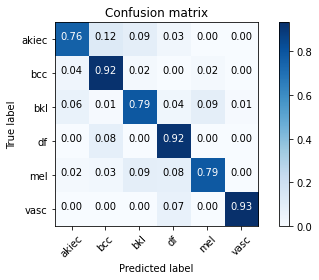

In [ ]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [ ]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[25  4  3  1  0  0]
 [ 2 48  1  0  1  0]
 [ 7  1 87  4 10  1]
 [ 0  1  0 11  0  0]
 [ 2  3 10  9 88  0]
 [ 0  0  0  1  0 14]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.69      0.76      0.72        33
         bcc       0.84      0.92      0.88        52
         bkl       0.86      0.79      0.82       110
          df       0.42      0.92      0.58        12
         mel       0.89      0.79      0.83       112
        vasc       0.93      0.93      0.93        15

    accuracy                           0.82       334
   macro avg       0.77      0.85      0.80       334
weighted avg       0.84      0.82      0.82       334



## TP FP FN TN

In [ ]:
cm_2 = confusion_matrix(test_labels, y_pred)

### TP

In [ ]:
TruePositive= np.diag(cm_2)

In [ ]:
print(TruePositive)
sumTruePositive = sum(TruePositive)
print('Sum of True Positive: ', sumTruePositive)

[25 48 87 11 88 14]
Sum of True Positive:  273


### FP

In [ ]:
FalsePositive = []
for i in range(NUM_CLASSES):
    FalsePositive.append(sum(cm_2[:,i]) - cm_2[i,i])

In [ ]:
print(FalsePositive)
sumFalsePositive = sum(FalsePositive)
print('Sum of False Positive: ', sumFalsePositive)

[11, 9, 14, 15, 11, 1]
Sum of False Positive:  61


### FN

In [ ]:
FalseNegative = []
for i in range(NUM_CLASSES):
    FalseNegative.append(sum(cm_2[i,:]) - cm_2[i,i])

In [ ]:
print(FalseNegative)
sumFalseNegative = sum(FalseNegative)
print('Sum of False Negative: ', sumFalseNegative)

[8, 4, 23, 1, 24, 1]
Sum of False Negative:  61


### TN

In [ ]:
TrueNegative = []
for i in range(NUM_CLASSES):
    temp = np.delete(cm_2, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))

In [ ]:
print(TrueNegative)
sumTrueNegative = sum(TrueNegative)
print('Sum of True Negative: ', sumTrueNegative)

[290, 273, 210, 307, 211, 318]
Sum of True Negative:  1609


## Check TP + FP + FN + TN = Test set

In [ ]:
l = len(test_labels)
for i in range(NUM_CLASSES):
    print(TruePositive[i] + FalsePositive[i] + FalseNegative[i] + TrueNegative[i] == l)

True
True
True
True
True
True


## PYCM

In [ ]:
!pip3 install pycm==3.0 

     |████████████████████████████████| 71kB 4.7MB/s 
     |████████████████████████████████| 573kB 8.8MB/s 


In [ ]:
from pycm import *

In [ ]:
py_cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=y_pred)

In [ ]:
py_cm.classes

[0, 1, 2, 3, 4, 5]

In [ ]:
py_cm.table

{0: {0: 25, 1: 4, 2: 3, 3: 1, 4: 0, 5: 0},
 1: {0: 2, 1: 48, 2: 1, 3: 0, 4: 1, 5: 0},
 2: {0: 7, 1: 1, 2: 87, 3: 4, 4: 10, 5: 1},
 3: {0: 0, 1: 1, 2: 0, 3: 11, 4: 0, 5: 0},
 4: {0: 2, 1: 3, 2: 10, 3: 9, 4: 88, 5: 0},
 5: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 14}}

In [ ]:
print(py_cm)

Predict  0        1        2        3        4        5        
Actual
0        25       4        3        1        0        0        

1        2        48       1        0        1        0        

2        7        1        87       4        10       1        

3        0        1        0        11       0        0        

4        2        3        10       9        88       0        

5        0        0        0        1        0        14       





Overall Statistics : 

95% CI                                                            (0.77593,0.8588)
ACC Macro                                                         0.93912
ARI                                                               0.59865
AUNP                                                              0.88489
AUNU                                                              0.90642
Bangdiwala B                                                      0.69026
Bennett S                                                  

### Average AUC

In [ ]:
AV_AUC = (py_cm.AUC[0] + py_cm.AUC[1] + py_cm.AUC[2] + py_cm.AUC[3] + py_cm.AUC[4] + py_cm.AUC[5])/len(py_cm.AUC)

In [ ]:
print('Average AUC: ', AV_AUC)

Average AUC:  0.9064206763701023


### Average Sensitivity

In [ ]:
AV_Sens = (py_cm.TPR[0] + py_cm.TPR[1] + py_cm.TPR[2] + py_cm.TPR[3] + py_cm.TPR[4] + py_cm.TPR[5])/len(py_cm.TPR)

In [ ]:
print('Average Sensitivity: ', AV_Sens)

Average Sensitivity:  0.8512126762126763


### Average Specificity

In [ ]:
AV_Spec = (py_cm.TNR[0] + py_cm.TNR[1] + py_cm.TNR[2] + py_cm.TNR[3] + py_cm.TNR[4] + py_cm.TNR[5])/len(py_cm.TNR)

In [ ]:
print('Average Specificity: ', AV_Spec)

Average Specificity:  0.961628676527528


## Grad-CAM

In [ ]:
last_conv2d = 'conv5_block16_2_conv'

### AKIEC

In [ ]:
akiec_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/akiec/ISIC_0026492.jpg' 

Model prediction:
	mel            	(4)	with probability 0.681
	akiec          	(0)	with probability 0.196
	df             	(3)	with probability 0.081
	bkl            	(2)	with probability 0.034
	bcc            	(1)	with probability 0.007
Explanation for 'mel'


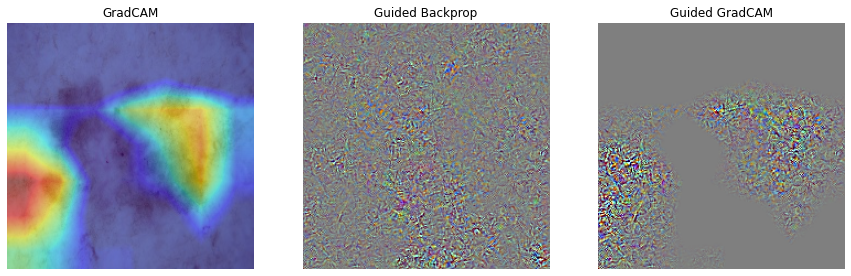

In [ ]:
 gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, akiec_img, layer_name=last_conv2d)

### BCC

In [ ]:
bcc_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/bcc/ISIC_0024332.jpg'

Model prediction:
	bcc            	(1)	with probability 0.956
	df             	(3)	with probability 0.028
	mel            	(4)	with probability 0.009
	akiec          	(0)	with probability 0.006
	bkl            	(2)	with probability 0.001
Explanation for 'bcc'


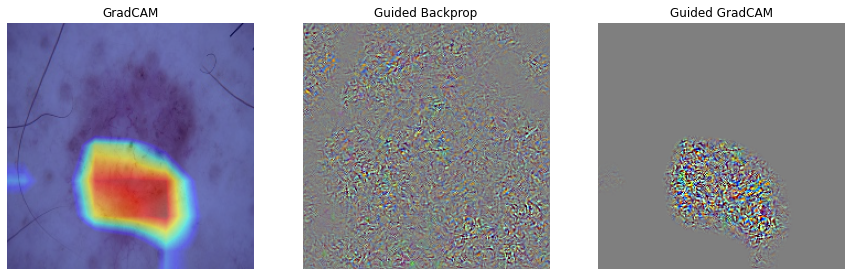

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, bcc_img, layer_name=last_conv2d)

### BKL

In [ ]:
bkl_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/bkl/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.891
	bkl            	(2)	with probability 0.099
	akiec          	(0)	with probability 0.005
	df             	(3)	with probability 0.004
	vasc           	(5)	with probability 0.000
Explanation for 'mel'


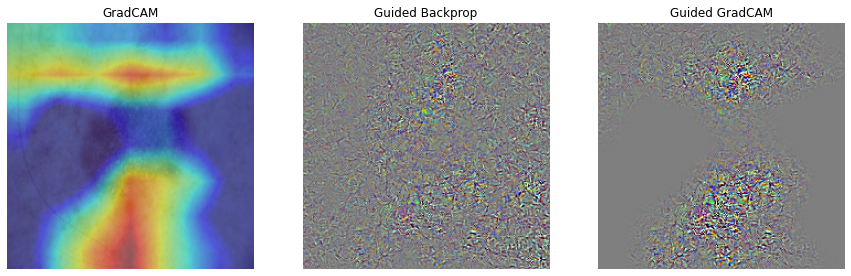

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, bkl_img, layer_name=last_conv2d)

### DF

In [ ]:
df_img = '/content/6_classes_HAM10000_split_Ver2/images/cc_val/df/ISIC_0033626.jpg'

Model prediction:
	df             	(3)	with probability 0.999
	mel            	(4)	with probability 0.001
	bkl            	(2)	with probability 0.000
	bcc            	(1)	with probability 0.000
	akiec          	(0)	with probability 0.000
Explanation for 'df'


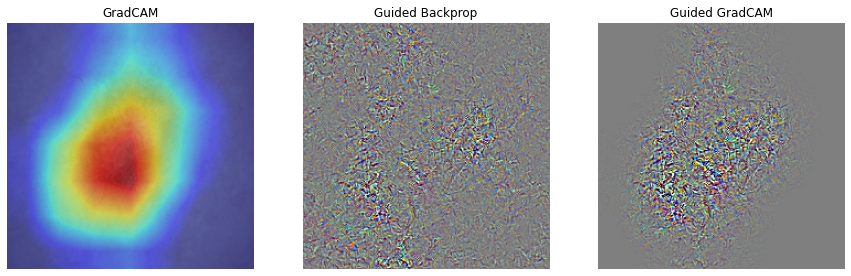

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, df_img, layer_name=last_conv2d)

### MEL

In [ ]:
mel_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/mel/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.995
	akiec          	(0)	with probability 0.003
	df             	(3)	with probability 0.002
	bkl            	(2)	with probability 0.001
	bcc            	(1)	with probability 0.000
Explanation for 'mel'


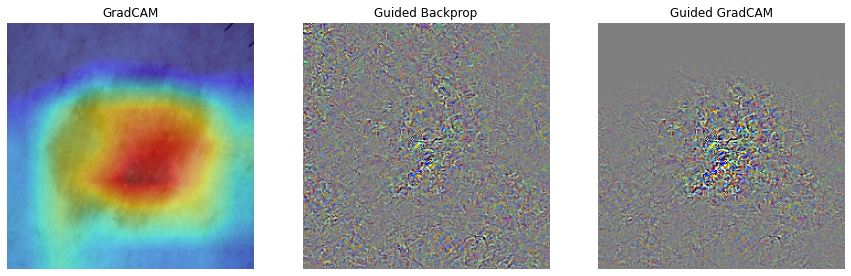

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, mel_img, layer_name=last_conv2d)

### VASC

In [ ]:
vasc_img = '/content/6_classes_HAM10000_split_Ver2/images/cc_test/vasc/ISIC_0025452.jpg'

Model prediction:
	vasc           	(5)	with probability 0.979
	mel            	(4)	with probability 0.014
	df             	(3)	with probability 0.004
	bkl            	(2)	with probability 0.003
	akiec          	(0)	with probability 0.000
Explanation for 'vasc'


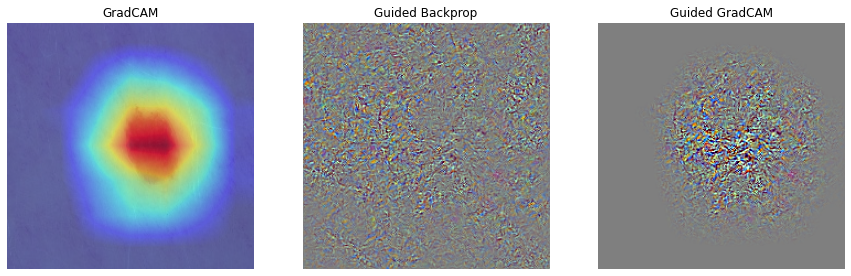

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, vasc_img, layer_name=last_conv2d)

# Download Model

In [ ]:
from google.colab import files

In [ ]:
files.download('/content/Ex2_HAM10000_DenseNet121_Oversampling_Ver2_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>